In [67]:
import scvi
import scanpy as sc
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import os
import torch
import sys
from datetime import datetime
import scarches as sca
from scipy.io import mmread

In [22]:
scvi.settings.progress_bar_style = "tqdm"
sc.set_figure_params(figsize=(4, 4), dpi=100, dpi_save=300)

nCores = 8
sc.settings.n_jobs = nCores
scvi.settings.num_threads = nCores

In [23]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    scvi.settings.seed = seed
    os.environ["PYTHONHASHSEED"] = str(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(123)

Seed set to 123


In [24]:
output_dir = "nba_integration/"
os.makedirs(output_dir, exist_ok=True)
output_tables = os.path.join(output_dir, "tables")
os.makedirs(output_tables, exist_ok=True)
output_figures = os.path.join(output_dir, "figures")
os.makedirs(output_figures, exist_ok=True)
sc.settings.figdir = output_figures

# Ref preprocessing 

In [ ]:
reference = sc.read_h5ad("preprocessing_data/NBatlas.h5ad")

In [ ]:
reference.X = reference.raw.X.copy()

In [ ]:
reference.layers["counts"] = reference.X.copy() 

In [ ]:
sc.pp.normalize_total(reference, target_sum=1e4)
sc.pp.log1p(reference)
reference.raw = reference  # freeze the state (with all genes) in .raw

In [ ]:
reference_full_path = os.path.join(output_dir, "reference_normalized_all_genes.h5ad")
print(f"Saving full normalized reference to {reference_full_path}")
reference.write_h5ad(reference_full_path)

In [ ]:
reference.obs['Study'] = reference.obs['Study'].astype('category').values

In [ ]:
sc.pp.highly_variable_genes(
    reference,
    n_top_genes=5000,  
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="Study" 
)

In [ ]:
has_existing_umap = 'X_scvi_umap' in reference.obsm

if has_existing_umap:
    print("Reference already has UMAP coordinates in 'X_scvi_umap' - preserving them")
    # Store original UMAP coordinates to restore later if needed
    original_umap = reference.obsm['X_scvi_umap'].copy()
    
    # For consistency with scanpy functions, also store as X_umap if not present
    if 'X_umap' not in reference.obsm:
        reference.obsm['X_umap'] = original_umap.copy()
else:
    print("No existing UMAP coordinates found in reference")

In [ ]:
sc.tl.pca(reference)

In [ ]:
sc.pp.neighbors(reference, n_pcs=20, n_neighbors=20)

In [ ]:
reference_hvg_path = os.path.join(output_dir, "reference_hvg5000.h5ad")
print(f"Saving reference with HVGs to {reference_hvg_path}")
reference.write_h5ad(reference_hvg_path)

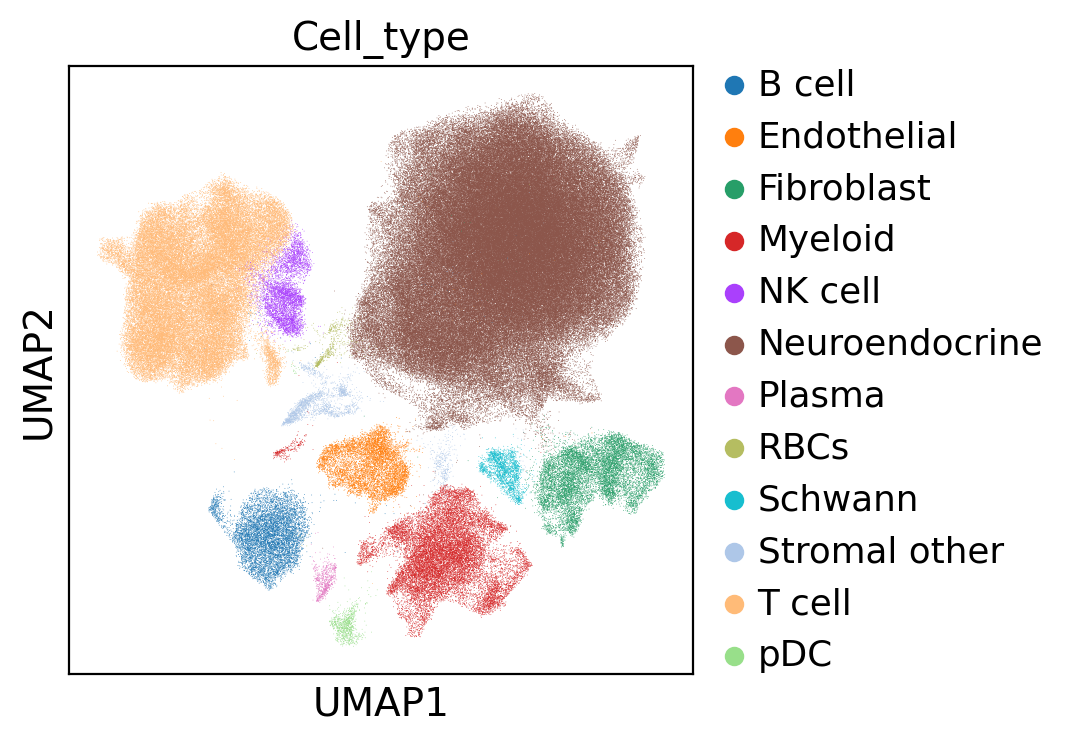

In [30]:
sc.pl.umap(
    reference,
    color = ["Cell_type"],
)

## SCVI

In [ ]:
scvi.model.SCVI.setup_anndata(
    reference,
    layer="counts",
    batch_key="Sample"
)

In [ ]:
model_kwargs = {
    "encode_covariates": True,
    "deeply_inject_covariates": False, 
    "use_layer_norm": "both",
    "use_batch_norm": "none",
    "n_layers": 2 
}

In [ ]:
scvi_model = scvi.model.SCVI(
    reference,
    **model_kwargs
)

In [ ]:
print(f"Start training scVI at {datetime.now().strftime('%H:%M:%S')}")
scvi_model.train(
    max_epochs=500,
    early_stopping=True
)
print(f"Finished training scVI at {datetime.now().strftime('%H:%M:%S')}")



In [27]:
scvi_model_dir = os.path.join(output_dir, "scvi_model")
print(f"Saving scVI model to {scvi_model_dir}")
scvi_model.save(scvi_model_dir, overwrite=True)

Saving scVI model to nba_integration/scvi_model


In [28]:
reference.obsm["X_scVI"] = scvi_model.get_latent_representation()
print("Getting normalized expression...")
normalized_expression = scvi_model.get_normalized_expression(
    library_size=1e4,
    n_samples=1
)
reference.layers["scvi_normalized"] = sp.sparse.csr_matrix(normalized_expression)

Getting normalized expression...


In [36]:
reference.obsm['X_umap_article'] = reference.obsm['X_scvi_umap'].copy()

In [41]:
print(reference.obsm['X_scVI'].shape)

(359793, 10)


In [40]:
reference

AnnData object with n_obs × n_vars = 359793 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mito', 'Study', 'Assay', 'Platform', 'Sample', 'Patient_No', 'Timepoint', 'INSS_stage', 'MYCN_amplification', 'Gender', 'Risk', 'Cell_condition', 'Cell_type', 'Cell_type_wImmuneZoomAnnot', '_scvi_batch', '_scvi_labels'
    var: 'features', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'Cell_type_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_scvi_umap', 'X_umap', 'X_pca', 'X_scVI', 'X_umap_article'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

In [42]:
sc.pp.neighbors(reference, n_pcs=10, n_neighbors=20, use_rep="X_scVI")
sc.tl.umap(reference, min_dist=0.6)

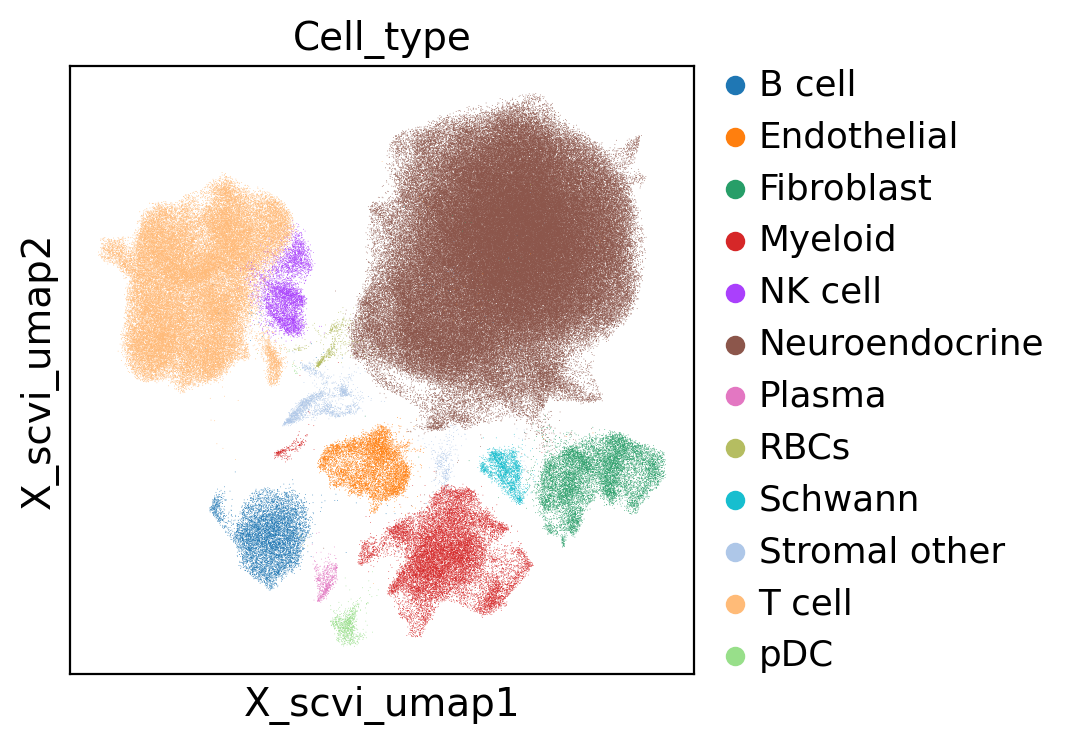

In [43]:
sc.pl.embedding(
    reference,
    color = ["Cell_type"],
    basis='X_scvi_umap'
)

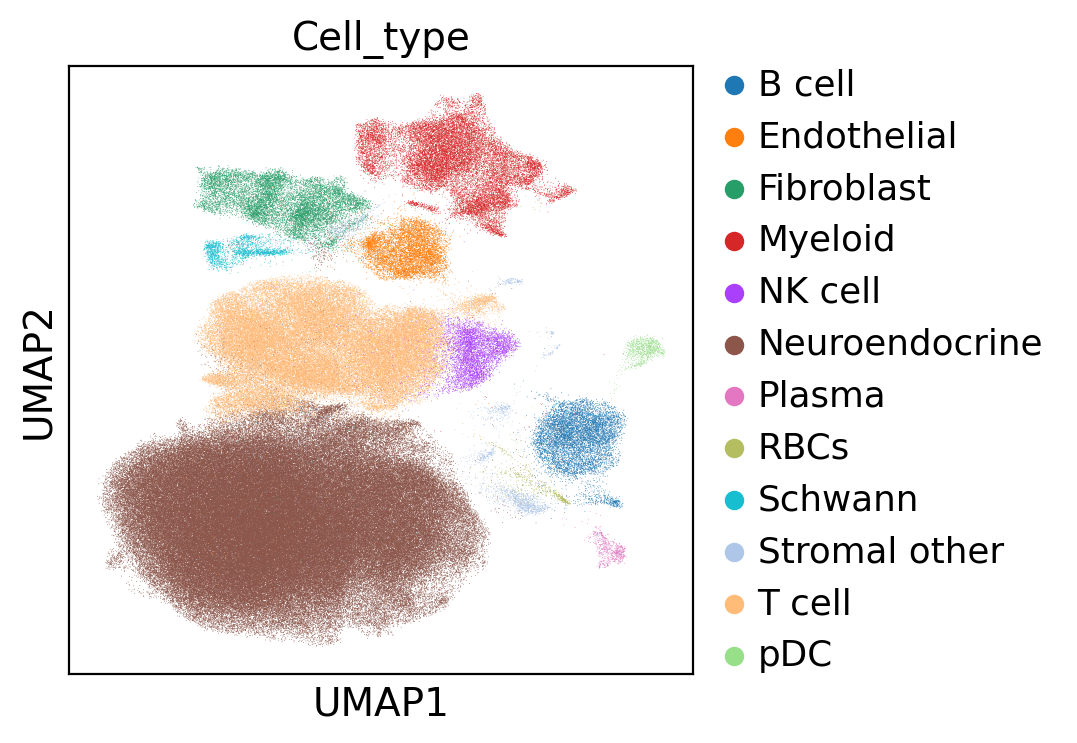

In [44]:
sc.pl.umap(
    reference,
    color = ["Cell_type"],
)

In [45]:
reference_scvi_path = os.path.join(output_dir, "reference_scvi_integrated.h5ad")
print(f"Saving scVI integrated reference to {reference_scvi_path}")
reference.write_h5ad(reference_scvi_path)

Saving scVI integrated reference to nba_integration/reference_scvi_integrated.h5ad


# Query preprocessing

In [96]:
query = sc.read_h5ad("preprocessing_data/ATLAS.h5ad")

In [97]:
query = query.raw.to_adata()

In [87]:
X_raw = mmread("preprocessing_data/ATLAS_raw_counts.mtx").T  # Transpose is required since `.mtx` stores genes as rows
genes = pd.read_csv("preprocessing_data/ATLAS_genes.csv", header=None)[0].tolist()[1:]
cells = pd.read_csv("preprocessing_data/ATLAS_cells.csv", header=None)[0].tolist()[1:]

In [98]:
query.var_names = pd.Index(genes)
query.obs_names = pd.Index(cells)
query.layers['counts'] = sp.sparse.csr_matrix(X_raw)

In [99]:
query.X = sp.sparse.csr_matrix(X_raw)

In [100]:
query.layers['counts'].data = np.round(query.layers['counts'].data).astype(int)

In [101]:
sc.pp.normalize_total(query, target_sum=1e4)
sc.pp.log1p(query)
query.raw = query

In [102]:
query_full_path = os.path.join(output_dir, "query_normalized_all_genes.h5ad")
print(f"Saving full normalized reference to {query_full_path}")
query.write_h5ad(reference_full_path)

Saving full normalized reference to nba_integration/query_normalized_all_genes.h5ad


In [103]:
query.obs['Study_method'] = query.obs['Study_method'].astype('category').values

In [104]:
sc.pp.highly_variable_genes(
    query,
    n_top_genes=5000,  
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="Study_method" 
)

In [106]:
sc.tl.pca(query)

In [107]:
sc.pp.neighbors(query, n_pcs=20, n_neighbors=20)

In [108]:
query_hvg_path = os.path.join(output_dir, "query_hvg5000.h5ad")
print(f"Saving reference with HVGs to {query_hvg_path}")
query.write_h5ad(query_hvg_path)

Saving reference with HVGs to nba_integration/query_hvg5000.h5ad


## SCVI

In [109]:
scvi.model.SCVI.setup_anndata(
    query,
    layer="counts",
    batch_key="SampleID"
)

In [110]:
model_kwargs = {
    "encode_covariates": True,
    "deeply_inject_covariates": False, 
    "use_layer_norm": "both",
    "use_batch_norm": "none",
    "n_layers": 2 
}

In [111]:
scvi_model_query = scvi.model.SCVI(
    query,
    **model_kwargs
)

In [ ]:
print(f"Start training scVI at {datetime.now().strftime('%H:%M:%S')}")
scvi_model_query.train(
    max_epochs=500,
    early_stopping=True
)
print(f"Finished training scVI at {datetime.now().strftime('%H:%M:%S')}")

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Start training scVI at 19:48:21


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.
/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.


Training:   0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
scvi_model_query_dir = os.path.join(output_dir, "scvi_model_query")
print(f"Saving scVI model to {scvi_model_query_dir}")
scvi_model_query.save(scvi_model_query_dir, overwrite=True)

# Integration

In [ ]:
common_genes = list(set(reference.var_names).intersection(set(query.var_names)))
print(f"Number of common genes: {len(common_genes)}")

In [ ]:
# Subset both datasets to common genes
reference = reference[:, common_genes].copy()
query = query[:, common_genes].copy()

In [47]:
cell_type_key = 'Cell_type'

In [48]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    adata=reference,
    scvi_model=scvi_model,
    labels_key=cell_type_key,
    unlabeled_category="not assigned",
    n_layers=4
)

/tmp/ipykernel_2972032/2946909771.py:1: UserWarning: Ignoring param 'n_layers' as it was already passed in to pretrained SCVI model with value 2.
  scanvi_model = scvi.model.SCANVI.from_scvi_model(


In [50]:
print(f"Start training scANVI at {datetime.now().strftime('%H:%M:%S')}")
scanvi_model.train(
    max_epochs=500,
    early_stopping=True
)
print(f"Finished training scANVI at {datetime.now().strftime('%H:%M:%S')}")

Start training scANVI at 18:49:24
INFO     Training for 500 epochs.                                                                                  


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.
/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of t

Training:   0%|          | 0/500 [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [46]:
reference

AnnData object with n_obs × n_vars = 359793 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mito', 'Study', 'Assay', 'Platform', 'Sample', 'Patient_No', 'Timepoint', 'INSS_stage', 'MYCN_amplification', 'Gender', 'Risk', 'Cell_condition', 'Cell_type', 'Cell_type_wImmuneZoomAnnot', '_scvi_batch', '_scvi_labels'
    var: 'features', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'Cell_type_colors', '_scvi_uuid', '_scvi_manager_uuid', 'umap'
    obsm: 'X_scvi_umap', 'X_umap', 'X_pca', 'X_scVI', 'X_umap_article'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

In [ ]:
query.obsm.keys()

In [51]:
query

NameError: name 'query' is not defined